In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import numpy as np

In [2]:
train_data = pd.read_csv('train_data.csv')

In [3]:
train_data['class'] = pd.cut(x=train_data['SalePrice'], bins=[train_data['SalePrice'].min() - 1, 100000, 350000, train_data['SalePrice'].max() + 1], labels=[0,1,2])

In [4]:
features = ['YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)',
       'N_Parkinglot(Basement)',  'N_manager',
       'N_elevators', 'N_FacilitiesInApt',
       'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
to_predict = ['class']

In [5]:
train_data = train_data[features + to_predict]

In [6]:
df_train = train_data[:3900]
df_val = train_data[3900:]

In [7]:
train_dataset = data.TensorDataset(torch.from_numpy(df_train.values[:,:-1]).float(), torch.from_numpy(df_train.values[:,-1].astype(np.dtype('int64'))))
val_dataset = data.TensorDataset(torch.from_numpy(df_val.values[:,:-1]).float(), torch.from_numpy(df_val.values[:,-1].astype(np.dtype('int64'))))

In [8]:
next(iter(train_dataset))

(tensor([2006.,  814.,    3.,  111.,  184.,    3.,    0.,    5.,    6.,    9.]),
 tensor(1))

In [9]:
# train_data

In [10]:
# train_data.columns

In [11]:
# train_data

In [12]:
# fig = plt.figure(figsize = (15,20))
# ax = fig.gca()
# train_data.hist(ax=ax)

In [13]:
test_data = pd.read_csv('test_data.csv')

In [14]:
# test_data

In [15]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(10, 20)
        self.bn1 = nn.BatchNorm1d(20)
        self.act_1 =  nn.ReLU()
        self.d1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(20, 40)
        self.bn2 = nn.BatchNorm1d(40)
        self.act_2 = nn.ReLU()
        self.d2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(40, 10)
        self.bn3 = nn.BatchNorm1d(10)
        self.act_3 = nn.ReLU()
        self.d3 = nn.Dropout(0.1)
        self.layer4 = nn.Linear(10, 3)
        self.act_4 = nn.ReLU()
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.d1(self.act_1(self.bn1(self.layer1(x))))
        x = self.d2(self.act_2(self.bn2(self.layer2(x))))
        x = self.d3(self.act_3(self.bn3(self.layer3(x))))
        x = self.layer4(x)
        # x = self.softmax(x)
        return x

In [16]:
# def get_accuracy(model, data):
#     correct = 0
#     total = 0
#     model.eval()
#     for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
#         # imgs, labels = imgs.to(device), labels.to(device)
#         output = model(imgs)
#         # print('OUT', output)
#         pred = output.max(1, keepdim=True)[1] # get the index of the max logit
#         # print('PRED', pred)
#         correct += pred.eq(labels.view_as(pred)).sum().item()
#         total += imgs.shape[0]
#     return correct / total

In [17]:
model = Classifier()
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=32,
                                               shuffle=True) # shuffle after every epoch
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=0)

In [18]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        # imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [19]:
def train(model, train, valid, batch_size=64, num_epochs=1, learn_rate=0.01, weight_decay=0):
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=learn_rate, weight_decay=weight_decay )
#     optimizer = optim.SGD(model.parameters(), lr=learn_rate,momentum=0.9, weight_decay=weight_decay)

    epochs, losses, train_acc, val_acc = [], [], [], []

    # training
#     n = 0 # the number of iterations
    for n in range(num_epochs):
        epoch_loss = 0
        train_accuracy = 0
        val_accuracy = 0
        printing = True
        for imgs, labels in iter(train_loader):
            # imgs, labels = imgs.to(device), labels.to(device)
            model.train()
            out = model(imgs)             # forward pass
            if printing:
                # print('OUT', out)
                printing = False
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         

            # save the current training information
            
            epoch_loss += float(loss)
            # losses.append(float(loss)/batch_size)        # compute *average* loss
            # train_acc.append(get_accuracy(model, train)) # compute training accuracy 
            # val_acc.append(get_accuracy(model, valid))   # compute validation accuracy
            train_accuracy += get_accuracy(model, train)
            val_accuracy += get_accuracy(model, valid)
            
            
        losses.append(epoch_loss/(batch_size * len(train_loader)))
        epochs.append(n)
        train_acc.append(train_accuracy/len(train_loader))
        val_acc.append(val_accuracy/len(train_loader))
        
        if n%10==0:
            print(f"Epoch {n}")
        
    
    plot_results(epochs, losses, train_acc, val_acc)

            

In [20]:
def plot_results(epochs, losses, train_acc, val_acc):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

Epoch 0
Epoch 10
Epoch 20
Epoch 30
Epoch 40
Epoch 50
Epoch 60
Epoch 70
Epoch 80
Epoch 90
Epoch 100
Epoch 110
Epoch 120
Epoch 130
Epoch 140
Epoch 150
Epoch 160
Epoch 170
Epoch 180
Epoch 190
Epoch 200
Epoch 210
Epoch 220
Epoch 230
Epoch 240
Epoch 250
Epoch 260
Epoch 270
Epoch 280
Epoch 290


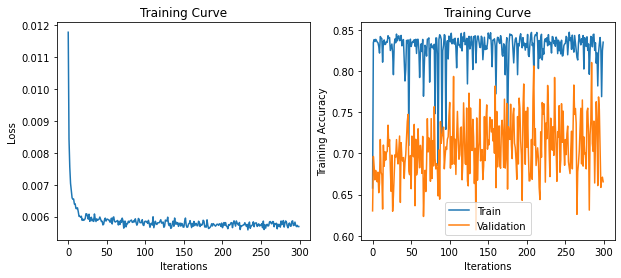

Final Training Accuracy: 0.8349222362337116
Final Validation Accuracy: 0.6654713114754097


In [21]:
train(model, train_dataset, val_dataset, num_epochs=300, learn_rate=0.0015, weight_decay=0.02)

In [22]:
# losses

In [23]:
# train_acc_loader = torch.utils.data.DataLoader(df_train, batch_size=100)
# val_acc_loader = torch.utils.data.DataLoader(df_val, batch_size=1000)

In [24]:
# model = Classifier()
# train(model, train_dataset, val_dataset, num_epochs=30, learning_rate = 0.1)

In [25]:
# saving model to file
state_dict = model.state_dict()
torch.save(state_dict, "neural_net.tar")